<a href="https://colab.research.google.com/github/kbhatia99/online_deep_learning/blob/main/readmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Data...
Merging Vitals & Labs...
Training ML Models...
Random Forest AUC: 0.575
XGBoost AUC: 0.597
Training Neural Network...
Epoch 1/10 | Loss: 0.1773
Epoch 2/10 | Loss: 0.1317
Epoch 3/10 | Loss: 0.1303
Epoch 4/10 | Loss: 0.1301
Epoch 5/10 | Loss: 0.1291
Epoch 6/10 | Loss: 0.1287
Epoch 7/10 | Loss: 0.1283
Epoch 8/10 | Loss: 0.1290
Epoch 9/10 | Loss: 0.1286
Epoch 10/10 | Loss: 0.1286
Neural Network AUC: 0.500


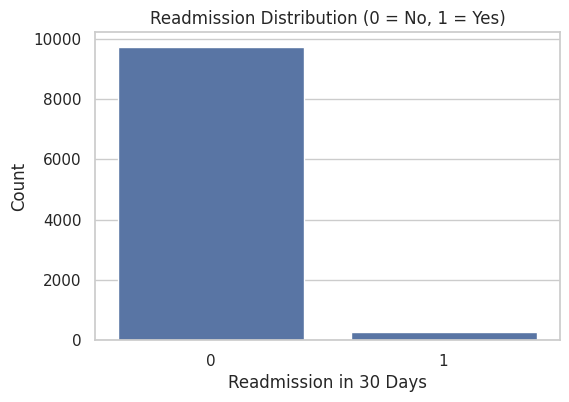

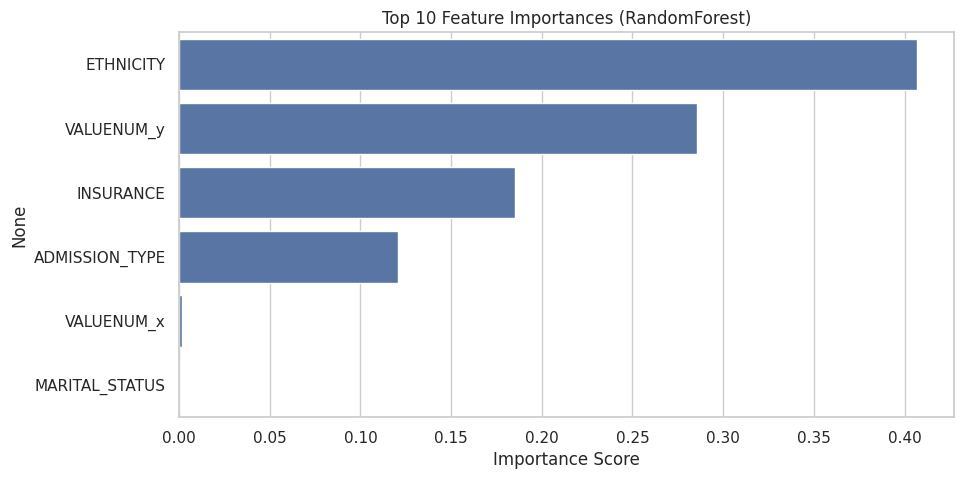

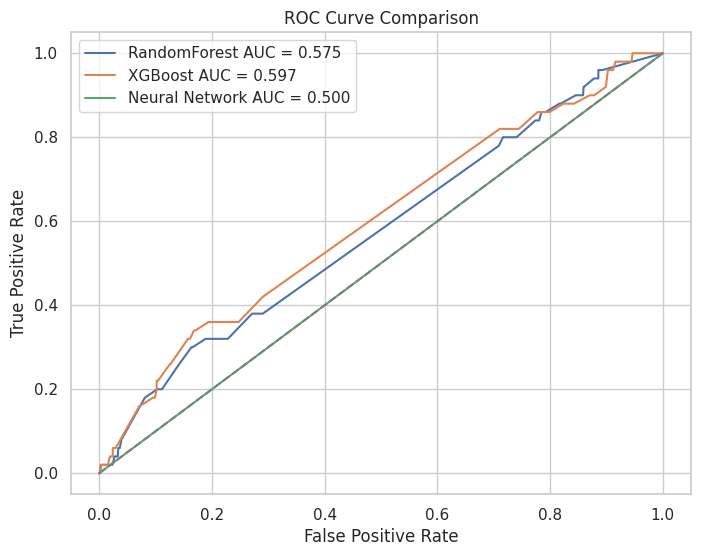

In [18]:
# Install dependencies if not installed
!pip install pandas numpy scikit-learn torch transformers xgboost seaborn matplotlib

# Import required libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

# --------------------------------------------
# Load MIMIC-III Data
# --------------------------------------------
print("Loading Data...")
admissions = pd.read_csv("/content/admissions.csv")

# Convert datetime columns
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])

# Identify 30-day readmissions
admissions = admissions.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])
admissions['NEXT_ADMIT'] = admissions.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)
admissions['READMISSION_30D'] = (admissions['NEXT_ADMIT'] - admissions['DISCHTIME']).dt.days <= 30
admissions['READMISSION_30D'] = admissions['READMISSION_30D'].astype(int)

# Select relevant features
admissions = admissions[['SUBJECT_ID', 'HADM_ID', 'INSURANCE', 'MARITAL_STATUS', 'ETHNICITY', 'ADMISSION_TYPE', 'READMISSION_30D']]

# Encode categorical features
categorical_features = ['INSURANCE', 'MARITAL_STATUS', 'ETHNICITY', 'ADMISSION_TYPE']
for col in categorical_features:
    admissions[col] = LabelEncoder().fit_transform(admissions[col].astype(str))

# Load vitals & labs (CHARTEVENTS.csv & LABEVENTS.csv)
print("Merging Vitals & Labs...")
vitals = pd.read_csv("/content/chartevents.csv")[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUENUM']]
labs = pd.read_csv("/content/labevents.csv")[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUENUM']]

# Aggregate values
vitals_summary = vitals.groupby(['SUBJECT_ID', 'HADM_ID'])['VALUENUM'].mean().reset_index()
labs_summary = labs.groupby(['SUBJECT_ID', 'HADM_ID'])['VALUENUM'].mean().reset_index()

# Merge with admissions
data = admissions.merge(vitals_summary, on=['SUBJECT_ID', 'HADM_ID'], how='left')
data = data.merge(labs_summary, on=['SUBJECT_ID', 'HADM_ID'], how='left')

# Fill missing values with median
data = data.fillna(data.median())

# Define target & features
X = data.drop(columns=['SUBJECT_ID', 'HADM_ID', 'READMISSION_30D'])
y = data['READMISSION_30D']

# --------------------------------------------
# Train-Test Split
# --------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------------------------
# Train Machine Learning Models
# --------------------------------------------
print("Training ML Models...")

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

print(f"Random Forest AUC: {rf_auc:.3f}")
print(f"XGBoost AUC: {xgb_auc:.3f}")

# --------------------------------------------
# Train Deep Learning Model (Neural Network)
# --------------------------------------------
print("Training Neural Network...")

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define Neural Network
class ReadmissionNN(nn.Module):
    def __init__(self, input_size):
        super(ReadmissionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ReadmissionNN(input_size=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model
losses = []

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

train_model(model, train_loader, criterion, optimizer, epochs=10)

# --------------------------------------------
# Evaluate Neural Network
# --------------------------------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device))
    y_pred = (y_pred > 0.5).float()
    nn_auc = roc_auc_score(y_test_tensor.numpy(), y_pred.cpu().numpy())

print(f"Neural Network AUC: {nn_auc:.3f}")

# --------------------------------------------
# Visualization
# --------------------------------------------

# Readmission Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Readmission Distribution (0 = No, 1 = Yes)")
plt.xlabel("Readmission in 30 Days")
plt.ylabel("Count")
plt.show()

# Feature Importance (Random Forest)
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance[:10], y=feature_importance.index[:10])
plt.title("Top 10 Feature Importances (RandomForest)")
plt.xlabel("Importance Score")
plt.show()

# ROC Curve Comparison
plt.figure(figsize=(8, 6))

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest AUC = {rf_auc:.3f}")

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost AUC = {xgb_auc:.3f}")

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred.cpu().numpy())
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network AUC = {nn_auc:.3f}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [5]:
from google.colab import files
uploaded = files.upload()

Saving chartevents.csv to chartevents.csv
